In [14]:
import os
import requests
import json
import pandas as pd
import numpy as np
import timeit
import datetime
import csv
import seaborn as sns
import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from dotenv import load_dotenv
from functools import partial

# We use the alpha-vantage package to pull historical CAD data
# Install package before importing: pip install alpha-vantage
# https://pypi.org/project/alpha-vantage/
from alpha_vantage.foreignexchange import ForeignExchange

In [15]:
# #########################################################
#     Pull Historical CAD data from alpha vantage API
# #########################################################

# Load .env enviroment variables
load_dotenv()
alpha_vantage_key = os.getenv("ALPHA_VANTAGE")

#Pull CAD Data
fx = ForeignExchange(key=alpha_vantage_key,output_format='pandas')
cad_data_raw, meta_data = fx.get_currency_exchange_daily(from_symbol='CAD', to_symbol='USD', outputsize='full')

# Save to CSV file
cad_data_raw.to_csv('../../02-Data/Dirty Data/Market Data/CAD_5yr_drt.csv')

# *** Format and clean CAD data ***

# Keep only Date and Close columns
cad_data = cad_data_raw.reset_index()
cad_data.drop(['1. open', '2. high', '3. low'], axis=1, inplace=True)

# Rename columns
cad_data.columns = ['Date', 'Close']

# Select only from 2015-10-01 to 2020-11-01
start_date = pd.Timestamp("10/31/2015")
end_date = pd.Timestamp("11/01/2020")

# Set Date column to 'Timestamp' format
cad_data['Date'] = pd.to_datetime(cad_data['Date'])

# Slice Dataframe
cad_data = cad_data[(cad_data['Date'] > (start_date)) & (cad_data['Date'] < (end_date))]

# Set index back
cad_data.set_index("Date", inplace = True)

# Sort Index
cad_data = cad_data.sort_index(ascending=True)

# Save to file
cad_data.to_csv('../../02-Data/Clean Data/Market Data/CAD_5yr_cln.csv')

cad_data.head()

Close
Date              
2015-11-02  0.7632
2015-11-03  0.7652
2015-11-04  0.7601
2015-11-05  0.7591
2015-11-06  0.7515

In [16]:
# ########################################################################
#  Pull Historical SP-TSX60 data from CSV file pulled from investing.com
# ########################################################################

# Clean TSX60 Dataframe
# TSX from 2015-10-01 to 2020-11-01
SP_TSX60_file = Path("../../02-Data/Dirty Data/Market Data/SPTSX60 Historical.csv")
SP_TSX60_data = pd.read_csv(SP_TSX60_file, index_col="Date")

# Remove useles column
SP_TSX60_data.reset_index(inplace=True)

# Convert Date column to datetime type
SP_TSX60_data['Date'] = pd.to_datetime(SP_TSX60_data['Date'])
SP_TSX60_data.sort_values(by='Date', ascending=True, inplace=True)

# Change column order and keep only relevant ones
SP_TSX60_data_sliced = SP_TSX60_data[['Date', 'Price']].set_index('Date')

# Convert Price column to float
SP_TSX60_data_sliced['Price'] = SP_TSX60_data_sliced['Price'].str.replace(',', '')
SP_TSX60_data_sliced['Price'] = SP_TSX60_data_sliced['Price'].astype(float)

# Save to CSV file
SP_TSX60_data_sliced.to_csv('../../02-Data/Clean Data/Market Data/SPTSX60_5yr_cln.csv')

SP_TSX60_data_sliced.head()

Price
Date              
2015-11-02  800.44
2015-11-03  804.91
2015-11-04  802.92
2015-11-05  794.97
2015-11-06  795.18

In [4]:
# #########################################################
#          Pull Covid data from arcgis.com API
# #########################################################

url = 'https://opendata.arcgis.com/datasets/4dabb4afab874804ba121536efaaacb4_0.geojson'
request_data = requests.get(url).json()

#print(json.dumps(request_data, indent=4))
# request_data['features'][0]['properties']
# len(request_data['features'])

# Convert json data to csv file
with open('../../02-Data/Dirty Data/covid_stats/covid_data1.csv', 'w', newline='') as f:
    fieldnames = ['ObjectId', 'row_id', 'date_reported', 'health_region', 'age_group', 
                  'gender', 'exposure', 'case_status', 'latitude', 'longitude', 'province',
                  'province_abbr', 'hr_uid']
    
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    writer.writeheader()
    
    nb_rows = len(request_data['features'])
    start = timeit.default_timer()

    for row in range(0,len(request_data['features'])):
        clear_output(wait=True)
        writer.writerow(request_data['features'][row]['properties'])

        stop = timeit.default_timer()

        if (row / nb_rows)*100 < 5:
            expected_time = 'Calculating...'
        else:
            time_perc = timeit.default_timer()
            expected_time = np.round( ( (time_perc-start) / (row / nb_rows))/60, 2)

        print('Current Progress:', np.round(row / nb_rows * 100, 2), '%')
        print('Current Run Time:', np.round((stop-start)/60, 2), 'minutes')
        print('Expected Run Time:', expected_time, 'minutes')
    
# ###################################
#    Format and clean Covid data 
# ###################################

# Read data from file
csvpath = Path('../../02-Data/Dirty Data/covid_stats/covid_data1.csv')
data = pd.read_csv(csvpath, encoding='latin-1')

# Select only relevant columns
data = data[['date_reported', 'age_group', 'case_status', 'exposure', 'gender', 'health_region', 'latitude', 'longitude', 'province']]

# Remove time from date column
data['date_reported'] = data['date_reported'].replace(r'12:00:00', '', regex=True)

# Remove Nulls
data.dropna(inplace=True)

# Saving to file
data.to_csv('../../02-Data/Clean Data/Covid/covid_clean.csv')

data.head()

Current Progress: 100.0 %
Current Run Time: 4.36 minutes
Expected Run Time: 4.36 minutes


date_reported age_group case_status       exposure  gender  \
0   2020/10/29      20-29   Recovered  Close Contact  Female   
1   2020/10/10        <20   Recovered   Not Reported    Male   
2   2020/07/30        <20   Recovered  Close Contact  Female   
3   2020/09/25      20-29   Recovered  Close Contact    Male   
4   2020/10/31      20-29      Active  Close Contact  Female   

                     health_region   latitude  longitude province  
0               Peel Public Health  43.761613 -79.813571  Ontario  
1  Durham Region Health Department  44.035150 -78.882498  Ontario  
2            Lambton Public Health  42.886275 -82.098372  Ontario  
3               Peel Public Health  43.761613 -79.813571  Ontario  
4               Peel Public Health  43.761613 -79.813571  Ontario

<ipython-input-17-8ca62bbe4222>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



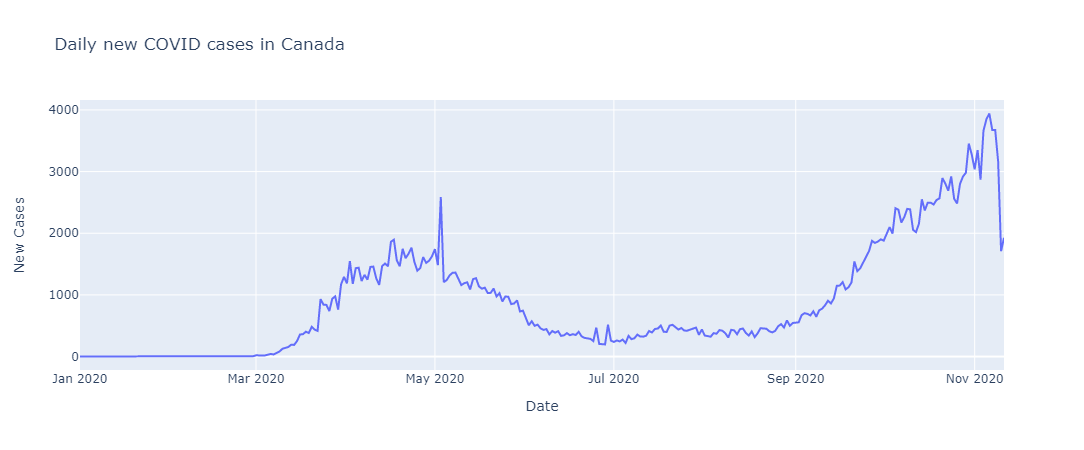

In [17]:
# #########################################################
#           Preparing Covid data for line plot
#          - Daily new COVID cases in Canada -
# #########################################################

# load_dotenv() # Previously ran above
map_box_api = os.getenv("MAPBOX")
px.set_mapbox_access_token(map_box_api)

file_path = Path("../../02-Data/Clean Data/Covid/covid_clean.csv")
covid_master = pd.read_csv(file_path, header=0, index_col=0)
cases_day = covid_master[['date_reported']]

# Adding a new column for the count
cases_day["count"] = 1

#Renaming columns
cases_day = cases_day.rename(columns={'date_reported':'Date', 'count':'New Cases'})

# Casting Date to Datetime type
cases_day['Date'] = pd.to_datetime(cases_day["Date"], infer_datetime_format=True)

cases_day = cases_day.set_index('Date')
cases_day.sort_index(ascending=True)

new_cases_sorted = cases_day.groupby('Date').count()
# new_cases_sorted.head()

covid_daily_cases = px.line(
    new_cases_sorted,
    y="New Cases",
    title="Daily new COVID cases in Canada"
)
covid_daily_cases

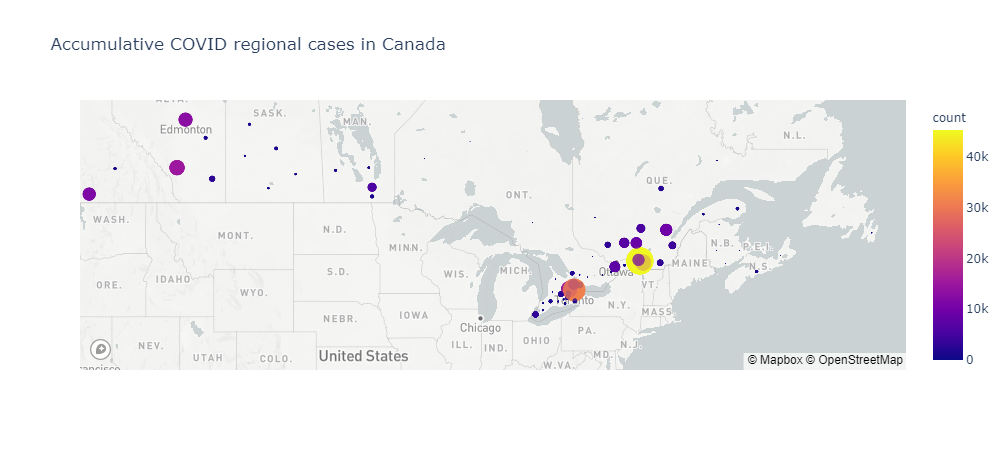

In [6]:
# #########################################################
#         Preparing Covid data for scatter map plot
#     - Accumulative COVID regional cases in Canada -
# #########################################################

covid_region = covid_master
covid_region["count"] = 1
covid_region=covid_region.drop(columns=["age_group", "case_status", "exposure", "province", "gender"])

covid_region = covid_region.groupby(['health_region','latitude','longitude', 'date_reported']).sum().groupby(level=0).cumsum().reset_index()

covid_region.sort_values("date_reported", inplace=True)

covid_region.to_csv("../../02-Data/Clean Data/Covid/covid_mapbox.csv")

map=px.scatter_mapbox(
    covid_region,
    lat="latitude",
    lon="longitude",
    size="count",
    color="count",
    title="Accumulative COVID regional cases in Canada",
    zoom=3
)

# Display the map
map.show()

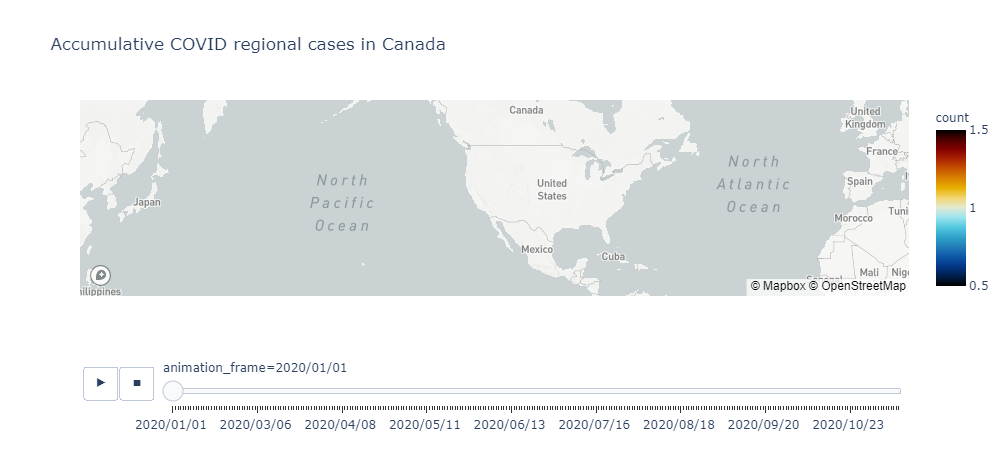

In [7]:
# #########################################################
#         Preparing Covid data for dynamic mapbox
#     - Accumulative COVID regional cases in Canada -
# #########################################################

covid_region_new = covid_region ['date_reported'].apply(str)
fig = px.scatter_mapbox(covid_region, lat="latitude", lon="longitude", animation_frame = covid_region_new, animation_group = 'health_region', 
                        color="count", size="count", color_continuous_scale=px.colors.cyclical.IceFire, 
                        size_max=20, zoom=2.6, hover_name='health_region', hover_data = ['count'], 
                        title = 'Accumulative COVID regional cases in Canada')
fig.show()

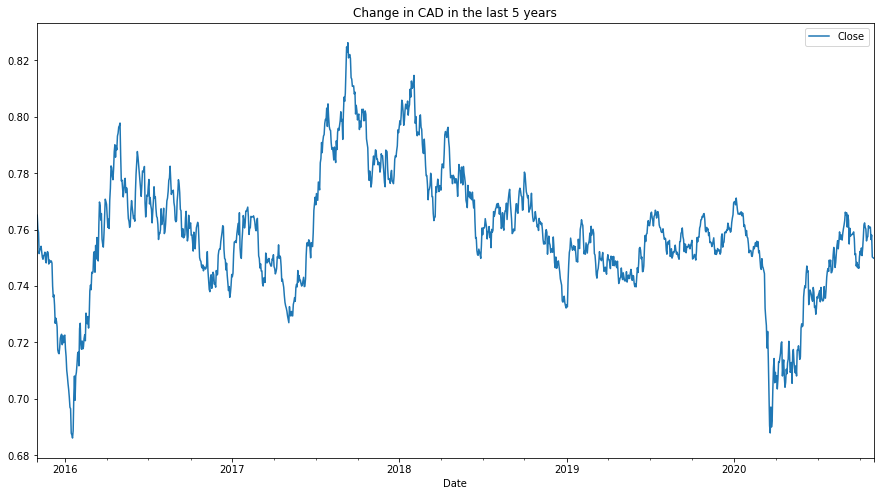

In [19]:
# #########################################################
#                     Wazarat's Plots (1)
#          - Change in CAD in the last 5 years -
# #########################################################

#PLOT CAD PRICES
cad_data.plot(figsize=(15,8), title="Change in CAD in the last 5 years")

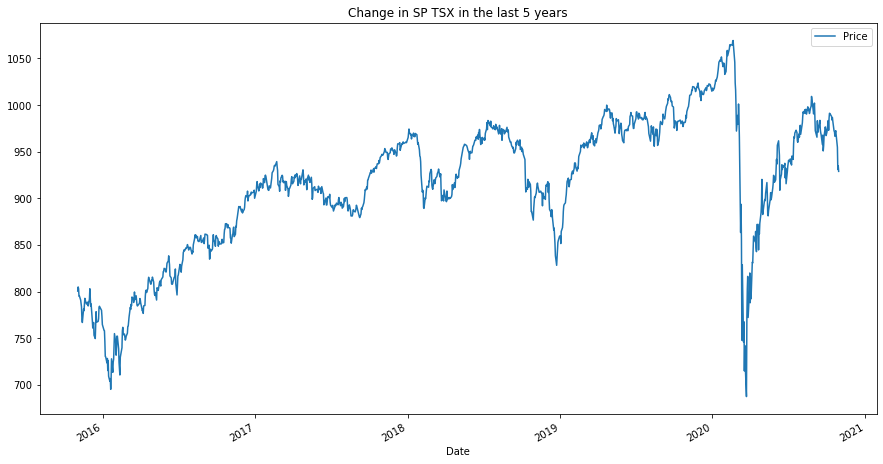

In [20]:
# #########################################################
#                     Wazarat's Plots (2)
#          - Change in SP TSX in the last 5 years -
# #########################################################
SP_TSX60_data_sliced.plot(figsize=(15,8), title="Change in SP TSX in the last 5 years")

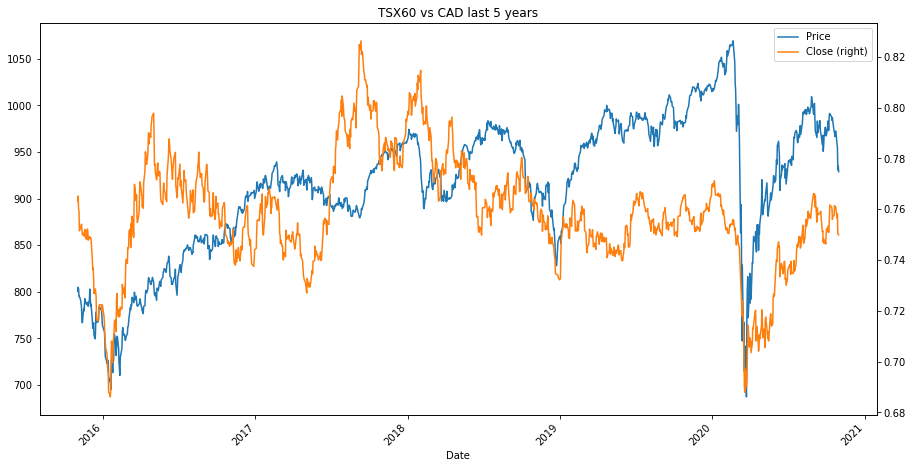

In [21]:
# #########################################################
#                     Wazarat's Plots (3)
#          - Change in SP TSX in the last 5 years -
# #########################################################

# Combine TSX60 and CAD
combined_df = pd.concat([SP_TSX60_data_sliced, cad_data], axis="columns", join="outer")

# Drop Nulls
combined_df = combined_df.dropna()

#THIS FUNCTION WILL SHOW THE FLUCTUATIONS OF BOTH DATAFRAMES TOGETHER 
#SINCE THE CLOSING PRICES ARE VERY DIFFERENT, WE CAN SEE THE Y AXIS FOR SP-TSX ON THE LEFT AND FOR CAD ON THE RIGHT 
combined_df[['Price','Close']].plot(
    secondary_y = 'Close', 
    rot=45, 
    figsize=(15, 8), 
    title='TSX60 vs CAD last 5 years'
)

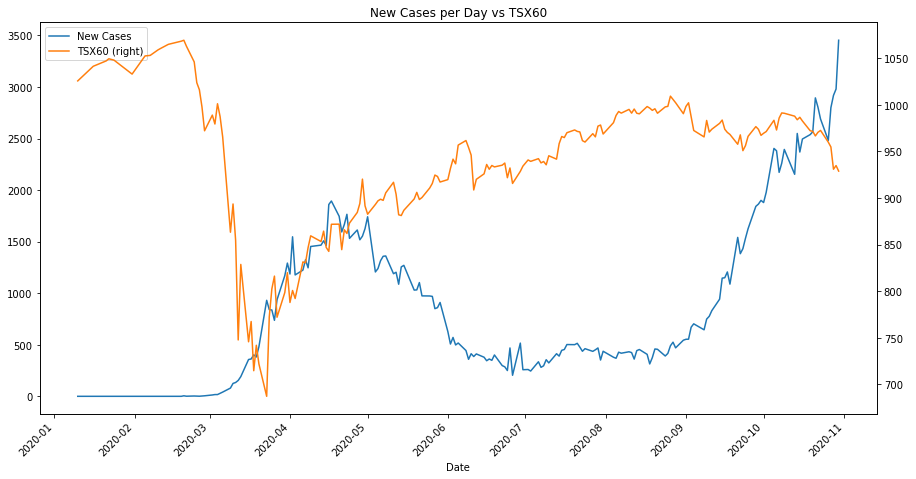

In [22]:
# ########################################################################
#  New section comparing 'New Cases/day' with TSX60
# #######################################################################

# Select only from 2020-01-01 to 2020-11-01
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2020, 11, 1)

# Rename Price column to TSX60 
tsx60 = SP_TSX60_data_sliced.copy()
tsx60.columns = ['TSX60']

# Select rows within date range
SP_TSX60_by_range = tsx60.loc[start_date: end_date]
new_cases_by_range = new_cases_sorted.loc[start_date: end_date]

# Join both data frames together 
tsx_vs_cases = new_cases_by_range.join(SP_TSX60_by_range, on='Date', how='left')

# Here we are losing new cases on weekend days because Nulls in TSX60 column
tsx_vs_cases.dropna(inplace=True)


#tsx_vs_cases

# Plotting New Cases per day vs. TSX60
tsx_vs_cases[['New Cases','TSX60']].plot(
    secondary_y = 'TSX60', 
    rot=45, 
    figsize=(15,8), 
    title='New Cases per Day vs TSX60'
)

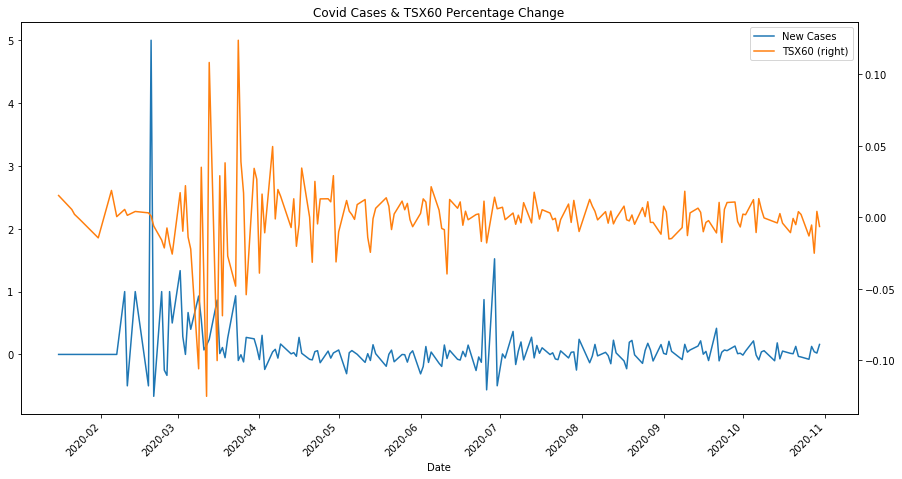

In [23]:
# Calculate Percentage Change
tsx_vs_cases_pct_change = tsx_vs_cases.copy()
tsx_vs_cases_pct_change = tsx_vs_cases_pct_change.pct_change()
tsx_vs_cases_pct_change.dropna(inplace=True)
#tsx_vs_cases_pct_change

# Same scale
#tsx_vs_cases_pct_change.plot(figsize=(15,8), title="Percentage Change")

# 2 different scales
tsx_vs_cases_pct_change[['New Cases','TSX60']].plot(
    secondary_y = 'TSX60', 
    rot=45, 
    figsize=(15,8), 
    title='Covid Cases & TSX60 Percentage Change'
)

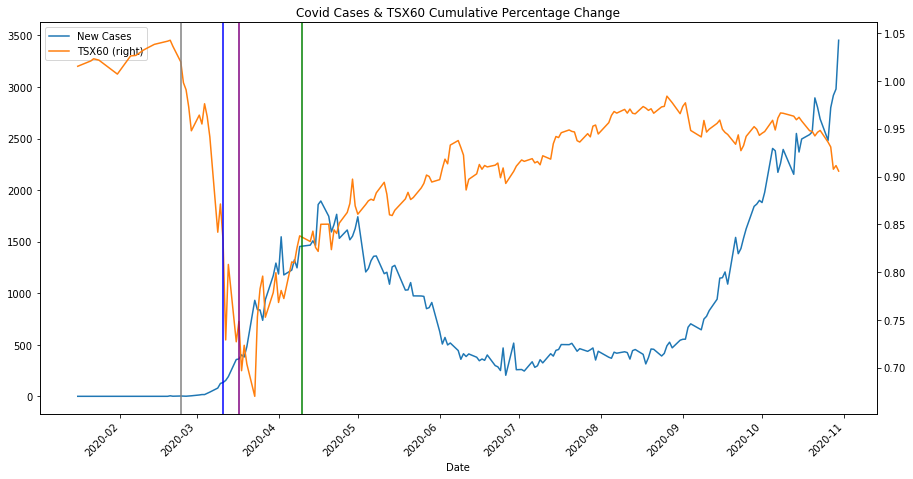

In [24]:
# Cumulative Percentage Change
tsx_vs_cases_cum_pct_change = (1 + tsx_vs_cases_pct_change).cumprod()
#tsx_vs_cases_cum_pct_change

# Same scale
#tsx_vs_cases_cum_pct_change.plot(figsize=(15,8), title="Cumulative Percentage Change")

# 2 different scales
tsx_vs_cases_cum_pct_change[['New Cases','TSX60']].plot(
    secondary_y = 'TSX60', 
    rot=45, 
    figsize=(15,8), 
    title="Covid Cases & TSX60 Cumulative Percentage Change"
)

# Adding vertical line for when Italy became the worst-hit country in Europe as cases spiked
plt.axvline(x='2020-02-24', color='gray', label="cerb")

# Adding vertical line for when the WHO declared the existence of a global pandemic.
plt.axvline(x='2020-03-11', color='blue', label="cerb")

# Adding vertical line for when the Borders got locked down
plt.axvline(x='2020-03-17', color='purple', label="cerb")

# Adding vertical line for when the RCMP disclosed it has been asked to enforce the Quarantine Act
plt.axvline(x='2020-04-10', color='green', label="cerb")

In [25]:
# Calculate correlation
tsx60_vs_cases_corr = tsx_vs_cases_cum_pct_change.corr()
tsx60_vs_cases_corr

New Cases     TSX60
New Cases   1.000000 -0.175306
TSX60      -0.175306  1.000000

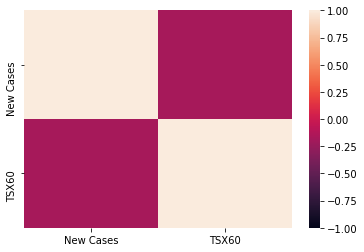

In [27]:
sns.heatmap(tsx60_vs_cases_corr, vmin=-1, vmax=1)

In [28]:
# #########################################################
#  New section comparing Cerb with TSX60
# #########################################################

# Get Cerb data
cerb_file_path = Path("../../02-Data/Clean Data/cerb/Weekday_cerb.csv")
cerb_data = pd.read_csv(cerb_file_path, header=0, index_col=0)

# Rename column and set date as datetime
cerb_data.reset_index(inplace=True)
cerb_data = cerb_data.rename(columns={'CERB Week End': 'Date', 'Total Paid CAD': 'Cerb'})
cerb_data['Date'] = pd.to_datetime(cerb_data['Date'])
cerb_data.set_index('Date', inplace=True)
#cerb_data.head()

# Get new TSX60 DataFrame
tsx60_data = SP_TSX60_data_sliced.copy()

# Rename Price column to TSX60 
tsx60_data.columns = ['TSX60']
#tsx60.head()

# Merge Cerb and TSX60 Data
cerb_tsx60_data = cerb_data.join(tsx60_data, on='Date', how='inner')
cerb_tsx60_data.head()

Cerb   TSX60
Date                      
2020-04-17  198.04  871.85
2020-04-24  242.50  873.14
2020-05-05  285.70  896.99
2020-05-11  304.82  916.89
2020-05-19  384.10  899.03

In [29]:
# Calculate Percentage Change
cerb_tsx60_pct_change = cerb_tsx60_data.pct_change()
cerb_tsx60_pct_change.dropna(inplace=True)
cerb_tsx60_pct_change

# # Cumulative Percentage Change
cerb_tsx60_cum_pct_change = (1 + cerb_tsx60_pct_change).cumprod()
cerb_tsx60_cum_pct_change

# # Calculate correlation
cerb_tsx60_corr = cerb_tsx60_cum_pct_change.corr()
cerb_tsx60_corr

Cerb     TSX60
Cerb   1.000000  0.881375
TSX60  0.881375  1.000000

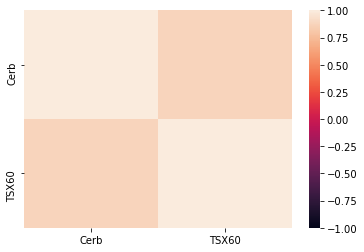

In [30]:
sns.heatmap(cerb_tsx60_corr, vmin=-1, vmax=1)